# Flatland project



 ## Import and procces the data

### Import necessary libraries

In [19]:
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import pickle, gzip
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F

### Load train and test data from files

In [21]:
# Load data function
def load_data(path_to_data):
    with gzip.open(path_to_data, 'rb') as file:
        X, y = pickle.load(file)
    return X, y

# Paths to data files
path_to_train_data = 'flatland_train.data'
path_to_test_data = 'flatland_test.data'

# Load the data
X, y = load_data(path_to_train_data)
X_TESTT, y_TESTT = load_data(path_to_test_data)

### Do a train-test split on the train data so we can check if the trained model is somewhat accurate

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Convert all of the data to tensors because we are working with pytorch, and you can send tensors to GPU.

In [23]:
# Train data from the split
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

# Test data from the split
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Main test data that we use in the end to get 10k character string
X_TESTT_tensor = torch.tensor(X_TESTT, dtype=torch.float32).unsqueeze(1)

### Create data set and data loader for the split data.

In [24]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor) # Pairs the training data X_train_tensor with its corresponding labels y_train_tensor
test_dataset = TensorDataset(X_test_tensor, y_test_tensor) # Pairs the testing data X_test_tensor with its corresponding labels y_test_tensor

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True) # Creates a loader for the train_dataset for efficient work
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False) # Creates a loader for the test_dataset for efficient work

### Image plot function

In [25]:
def plot(image, label=None):
    # Convert to NumPy if the image is a tensor
    if isinstance(image, torch.Tensor):
        image = image.squeeze().cpu().numpy()  # Remove channel dimension and move to CPU if necessary

    plt.imshow(image, cmap='gray')
    if label is not None:
        plt.title(f"Label: {label}")
    plt.show()

### Test the image plot function

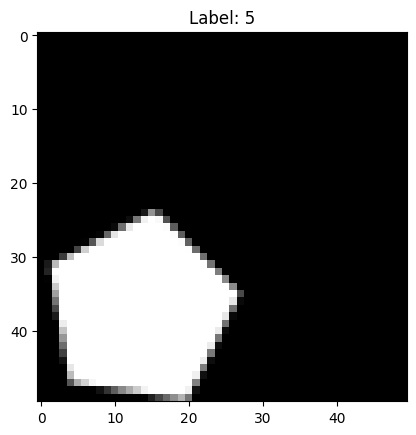

In [26]:
image, label = train_loader.dataset[0]
plot(image, label)

### Check if CUDA (GPU) is available, otherwise check for MPS, else use CPU

In [27]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


## Neural network
### Convolutional neural network architecture

In this architecture we use 3 convolutional layers, batch normalization after each one, max pooling, 2 fully connected layers with 50% dropout

In [92]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Convolutional layers
        # 1st conv. layer - input 1 image, output 32 features
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32) # stabilize and speed up training by normalizing weights

        # 2nd conv. layer - input 32 features, output 64 features
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64) # stabilize and speed up training by normalizing weights

        # 3rd conv. layer - input 64 features, output 128 features
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128) # stabilize and speed up training by normalizing weights


        # Pooling layer
        # Used to reduce weight and height by half
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 6 * 6, 64) # 128 channels and 6x6 feature maps after pooling
        self.fc2 = nn.Linear(64, 8)

        # Dropout layer
        # Used to prevent overfitting
        self.dropout = nn.Dropout(0.5)


    def forward(self, x):
        # Convolutional layers with batch normalization, relu, and maxpooling
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))

        # Flatten the tensor so it can be passed through fully connected layers
        x = x.view(x.size(0), -1)
        #x = torch.flatten(x, 1)

        # Fully connected layers with dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)

        return x

model = CNN().to(device) # Create model, send to device
criterion = nn.CrossEntropyLoss() # Cross Entropy Loss for criterion
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # Adam with learning rate of 0.001 optimizer

## Model training

In [115]:
# Number of epochs to train
num_epochs = 150

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        # Move data to the device (GPU or CPU)
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()  # Clear gradients
        loss.backward()  # Backpropagation
        optimizer.step()  # Update parameters

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset) # Calculate average loss for the epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.5f}")

Epoch [1/150], Loss: 0.03216
Epoch [2/150], Loss: 0.03098
Epoch [3/150], Loss: 0.03925
Epoch [4/150], Loss: 0.03076
Epoch [5/150], Loss: 0.02863
Epoch [6/150], Loss: 0.03931
Epoch [7/150], Loss: 0.03910
Epoch [8/150], Loss: 0.03604
Epoch [9/150], Loss: 0.03953
Epoch [10/150], Loss: 0.03711
Epoch [11/150], Loss: 0.03867
Epoch [12/150], Loss: 0.04069
Epoch [13/150], Loss: 0.03142
Epoch [14/150], Loss: 0.03635
Epoch [15/150], Loss: 0.02895
Epoch [16/150], Loss: 0.03593
Epoch [17/150], Loss: 0.03064
Epoch [18/150], Loss: 0.03034
Epoch [19/150], Loss: 0.04289
Epoch [20/150], Loss: 0.04387
Epoch [21/150], Loss: 0.03450
Epoch [22/150], Loss: 0.03717
Epoch [23/150], Loss: 0.03671
Epoch [24/150], Loss: 0.03727
Epoch [25/150], Loss: 0.04151
Epoch [26/150], Loss: 0.03796
Epoch [27/150], Loss: 0.02951
Epoch [28/150], Loss: 0.03108
Epoch [29/150], Loss: 0.02827
Epoch [30/150], Loss: 0.02786
Epoch [31/150], Loss: 0.03622
Epoch [32/150], Loss: 0.03780
Epoch [33/150], Loss: 0.04294
Epoch [34/150], Los

## Trained model evaluation

Do some tests on the test split

In [116]:
model.eval()
correct = 0
total = 0

with torch.no_grad():  # Disable gradient computation for evaluation
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)  # Get the index of the max log-probability
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 98.25%


Now use the trained model on main test set to get a prediction of an array of 10k characters, save the string to a file

In [117]:
# Set model to evaluation mode
model.eval()

# Initialize an empty string to hold the predictions
prediction_string = ""

with torch.no_grad():  # No need to track gradients
    for image in X_TESTT_tensor:
        image = image.unsqueeze(0).to(device)  # Add batch dimension and move to device
        output = model(image)
        _, predicted = torch.max(output, 1)  # Get the class with the highest probability
        prediction_string += str(predicted.item())  # Append prediction to string

# Write the prediction string to a new file
with open("predictions.txt", "w") as f:
    f.write(prediction_string)

Check string

In [118]:
prediction_string

'665553334330006334054556564553046305035566033300436336436666405355330365550305335053066350035535556353040336533535503003536065000465553044545554365535504654563563563655630353665636566036030566646353633536333633646535330605356655335035005350006334606034665350045363345644655635450334630035455365505353330643405536345340303060530005365550633456054433005436350034304435064546334606030656330565364503535653333663633066064335556435453606365543366330405553450350534555305066430030345354450503030634500655433330050663654433033403564353535365040333036355343560355636344055054340343045056550530353453665435543503500545306656456603640333046345636450656304355334334535056305355666056453333635033435634535335306033304353343350455643333403563005445055450364360050335563365630055330303303646345456053645343366060560433545653640333003550546406656543055303330534054453063364363565336503003553044035653535406355603303643335456063503655050464006535433036063063565640336363564643540500056635530535560303530045366535660

In [120]:
torch.save(model, 'model.pth')